# Design Filtering

This notebook demonstrates filtering protein designs interactively.

The filtering pipeline consumes the aggregated metrics produced by **Analyze** (i.e. `aggregate_metrics_*.csv`), applies hard filtering thresholds, ranks candidates by a composite quality key, and then performs a lazy-greedy **diversity selection** over sequence identity.

The filtering step writes:

- A CSV with all metrics and ranks  
- The top-`budget` quality + diversity designs (CIF files giving refolded coordinates)
- A summary PDF with tables, histograms, scatter plots, and (optionally) sequence logos and liability heat-maps

## Key Parameters

### Core Parameters
- **`design_dir`**: Directory containing design artifacts and metrics, including `aggregate_metrics_*.csv`
- **`outdir`**: Parent directory where results will be written into a subdirectory called "final_ranked_designs"
- **`budget`**: Number of designs to select by quality+diversity (Diverse set)

### Filtering Options
- **`use_affinity`**: Switch to affinity-oriented metrics (for small-molecule binders)
- **`from_inverse_folded`**: If True, use backbone RMSDs (`bb_rmsd`) for filtering and delta-SASA from refolded structures
- **`filter_designfolding`**: Also require the isolated design (no target) to refold to the same shape
- **`filter_bindingsite`**: Keep only designs with at least one residue within the specified distance of a binding-site residue
- **`filter_target_aligned`**: Require target backbone alignment
- **`filter_biased`**: Remove amino-acid composition outliers (default caps on ALA/GLY/GLU/LEU/VAL)
- **`refolding_rmsd_threshold`**: Threshold used for the RMSD-based filters

### Optimization Parameters
- **`alpha`**: Trade-off for sequence diversity selection (0=quality-only, 1=diversity-only)
- **`modality`**: Affects liability scoring and optional sequence visualizations ("peptide" or "antibody")

### Metrics Configuration
- **`metrics_override`**: Per-metric *inverse-importance* weights for ranking
  - A larger value **down-weights** that metric's rank (rank / weight)
  - `None` removes the metric entirely from the ranking key
- **`additional_filters`**: Extra hard filters of the form: `{"feature": "<column>", "lower_is_better": bool, "threshold": float}`
- **`size_buckets`**: Optional constraint for the maximum number of designs returned in a certain size range

## Ranking & Diversity Algorithm

### Filtering
Each design must pass all hard thresholds (`pass_<feature>_filter`). The step also adds convenience columns (e.g., `filter_rmsd`, `designfolding-filter_rmsd`, signed variants like `neg_min_design_to_target_pae`).

### Ranking (Quality)
For each metric in `self.metrics`, compute the row's rank on the tuple `(num_filters_passed, metric)` (so designs that fail filters are pushed down), then divide by the metric's *inverse-importance* weight. The **worst** (max) scaled rank across metrics becomes the design's quality key. The Top set is the best `budget` designs by this key (tie-broken by iPTM).

### Diversity Selection
A lazy-greedy selection chooses `div_budget` designs maximizing: `(1 - alpha) * quality + alpha * (1 - seq_identity)`. Sequence identity is computed via pairwise alignment on the full chain or the designed segment (auto-chosen based on typical length ratio). Optional `size_buckets` limit the number of selections per length range.

## Inputs & Outputs

### Required Inputs
- `design_dir/aggregate_metrics_*.csv` (required)
- `design_dir/ca_coords_sequences.pkl.gz` (required for diversity)
- `design_dir/refold_cif/` (optional but recommended, copied to outputs)

### Outputs
On disk (under `{outdir}/final_ranked_designs`):
- `final_{budget}_designs` folder with .mmcif files
- `metrics_*.csv` – full table with ranks/flags
- `diverse_selected_{div_budget}.csv` – rows/IDs for Diverse set
- `results_overview_*.pdf` – summary report with tables/plots

Total number of designs:    20
Duplicates found: 0. Removing duplicates. 20 designs remain.

Num designs that pass the has_x filter with threshold 0 where lower is better: 20
Remaining designs: 20
Num designs that pass the filter_rmsd filter with threshold 2.5 where lower is better: 4
Remaining designs: 4
Num designs that pass the filter_rmsd_design filter with threshold 2.5 where lower is better: 15
Remaining designs: 4
Num designs that pass the CYS_fraction filter with threshold 0 where lower is better: 16
Remaining designs: 2
Num designs that pass the ALA_fraction filter with threshold 0.2 where lower is better: 12
Remaining designs: 1
Num designs that pass the GLY_fraction filter with threshold 0.2 where lower is better: 19
Remaining designs: 1
Num designs that pass the GLU_fraction filter with threshold 0.2 where lower is better: 20
Remaining designs: 1
Num designs that pass the LEU_fraction filter with threshold 0.2 where lower is better: 20
Remaining designs: 1
Num designs that 

Performing lazy greedy diversity optimization.:   0%|          | 0/4 [00:00<?, ?it/s]

copy top design files: 0it [00:00, ?it/s]

copy diversity files:   0%|          | 0/5 [00:00<?, ?it/s]

Files + CSV saved to /tmp/workbench/tpp4/refiltered/final_ranked_designs

Writing design files is done. Now making plots for a final summary .pdf file with statistics.


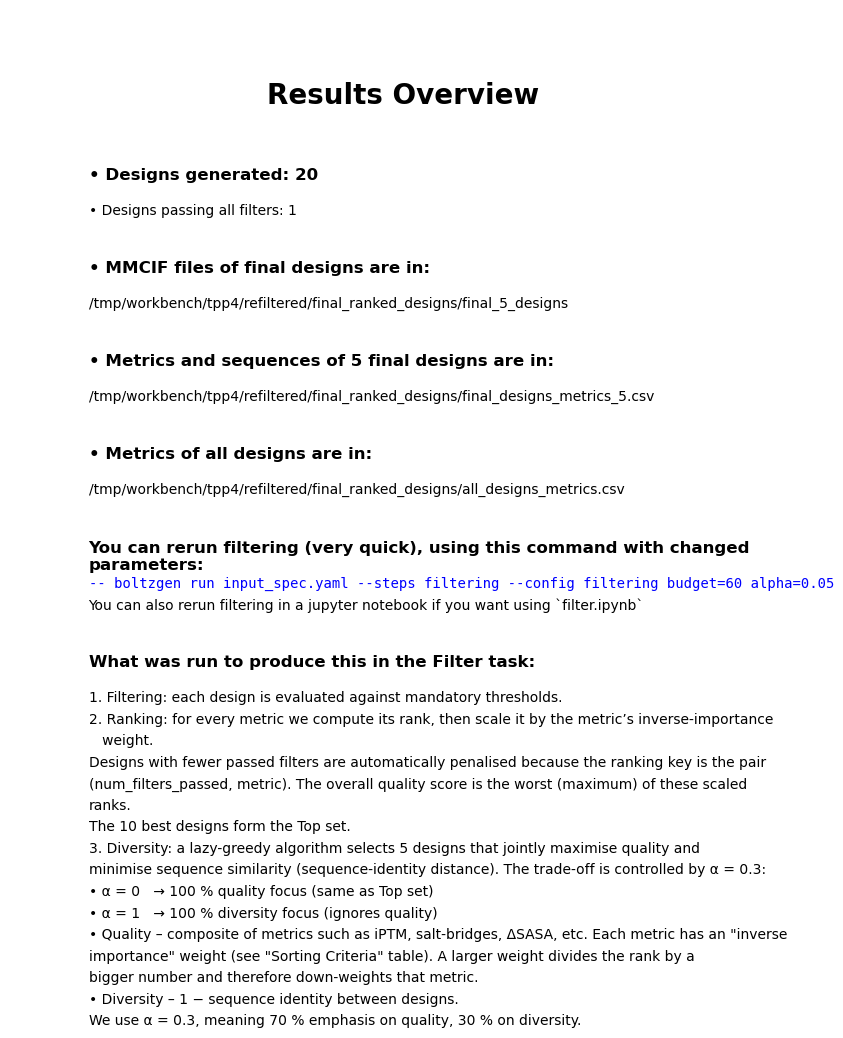

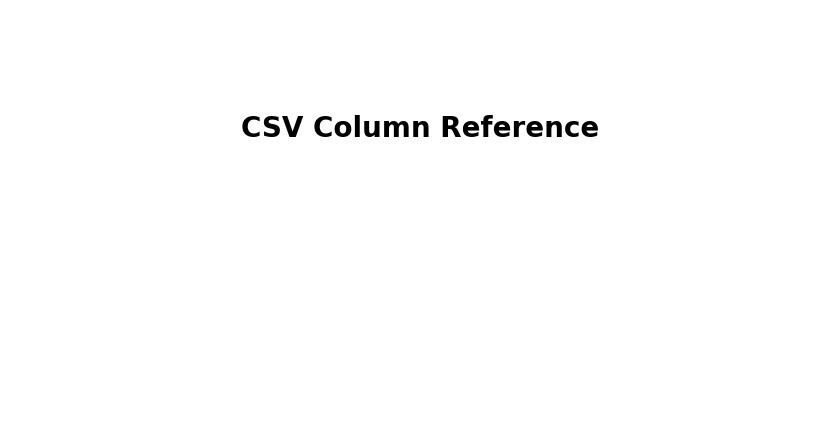

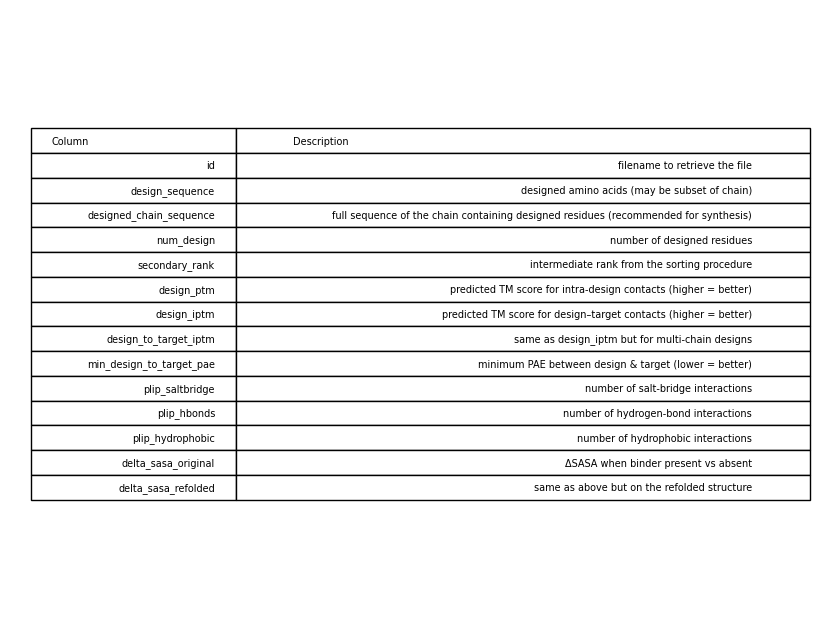

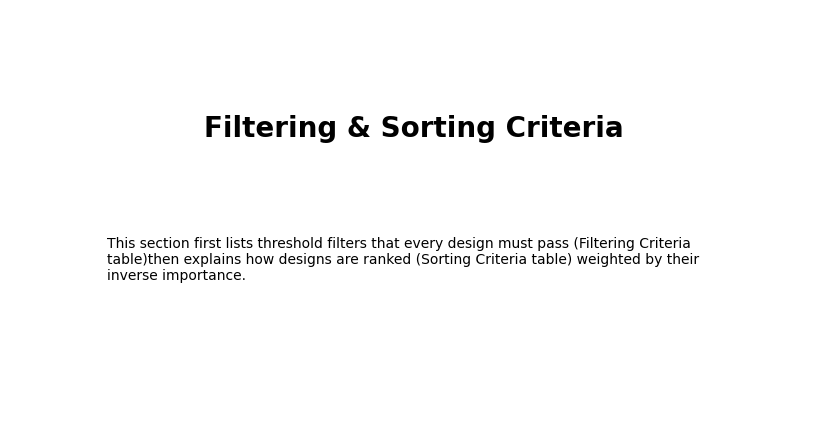

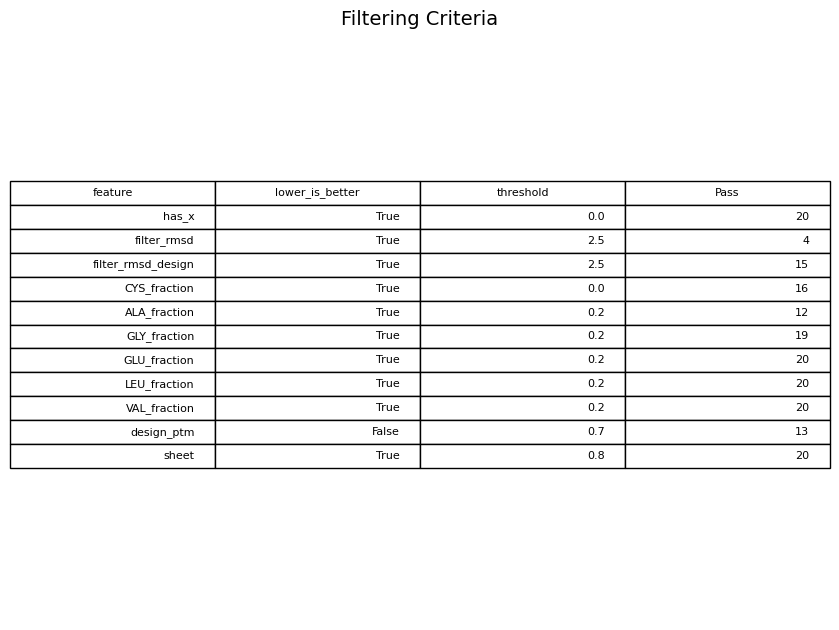

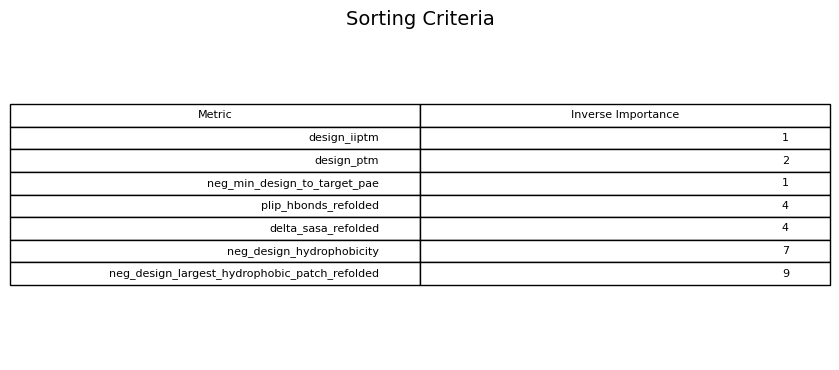

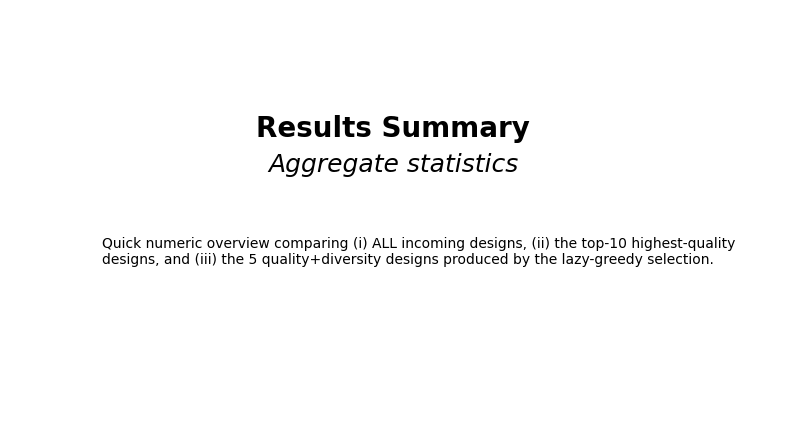

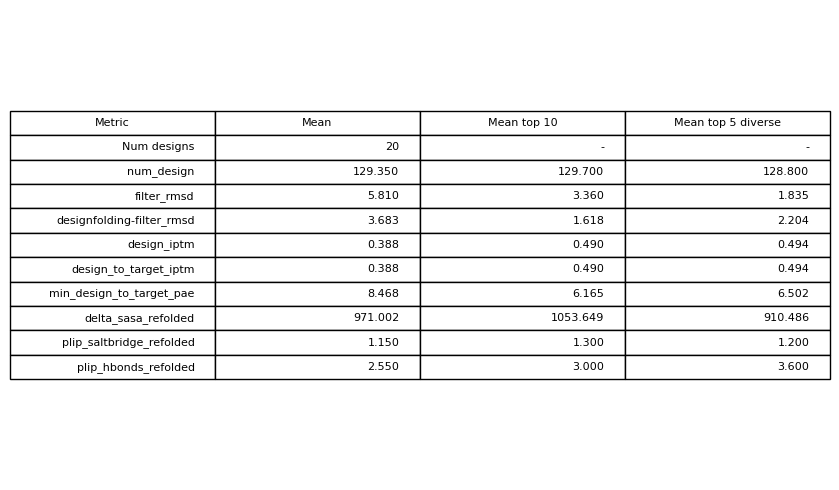

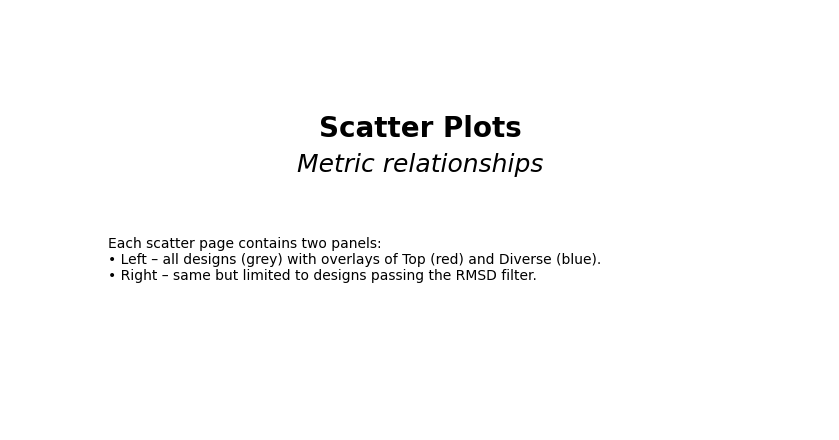

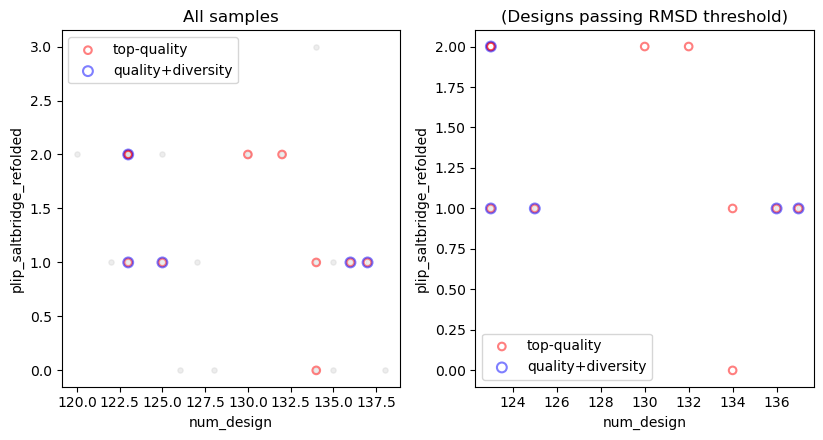

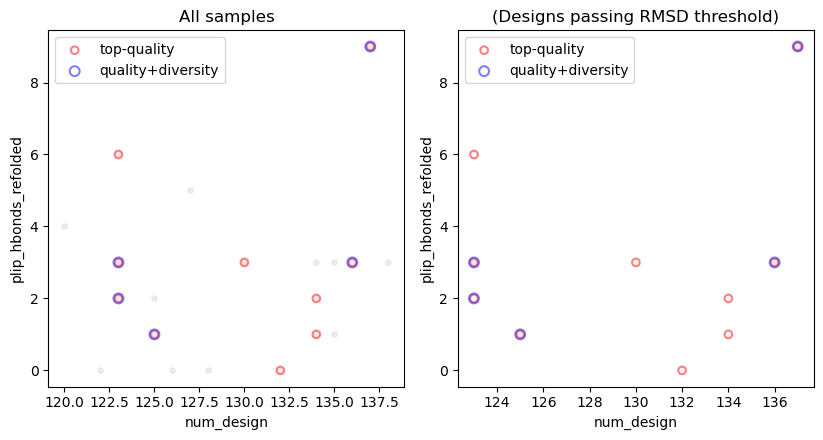

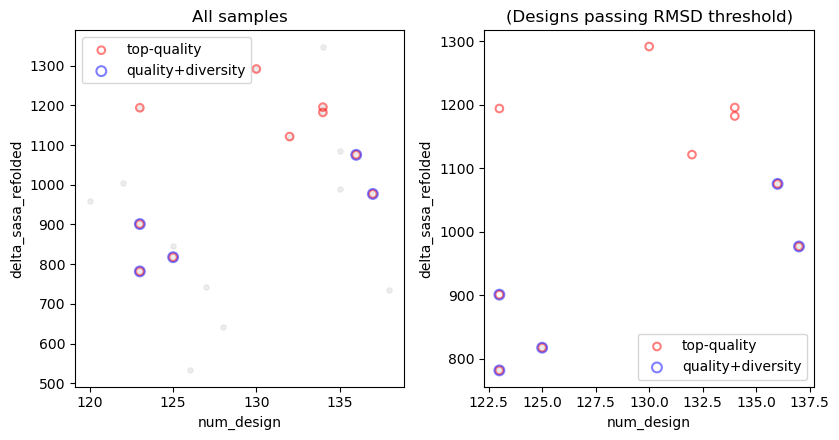

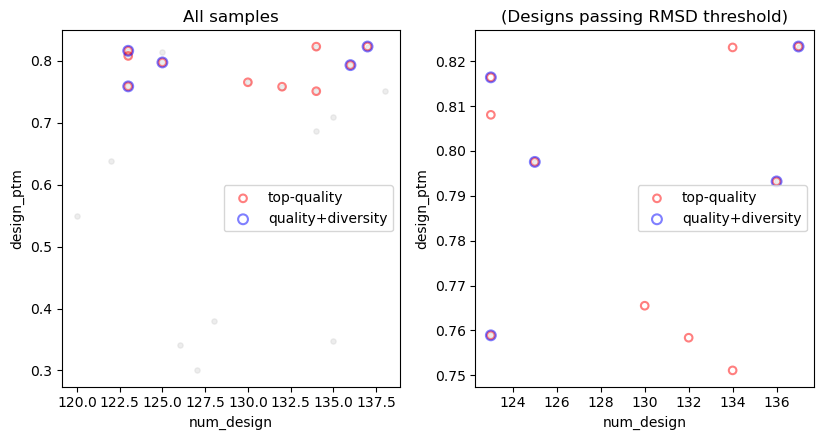

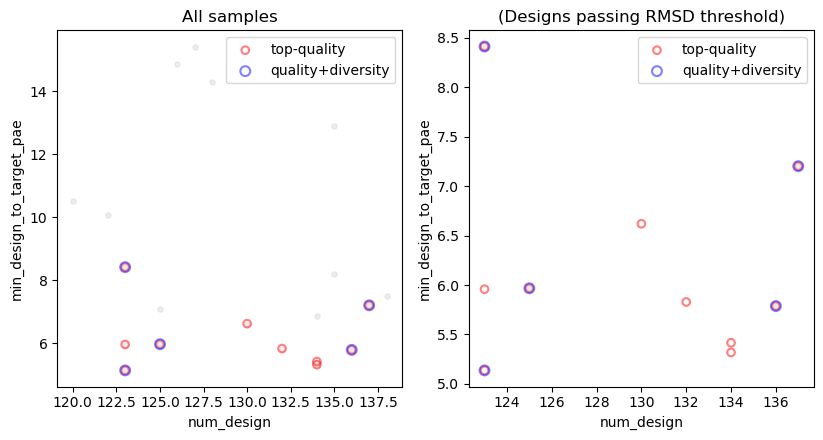

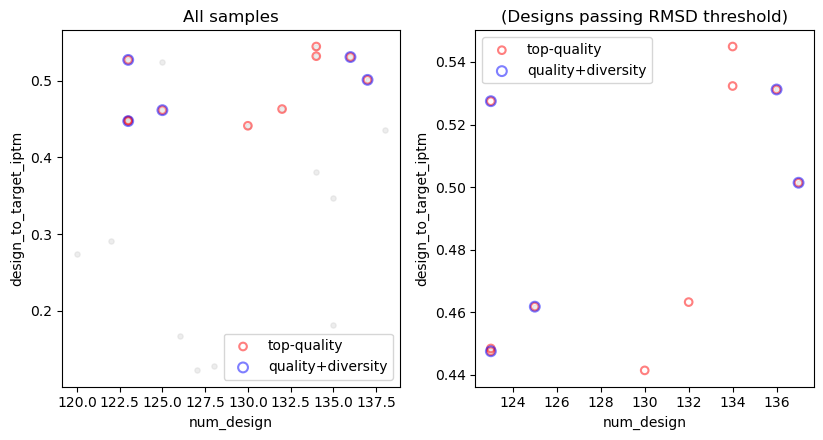

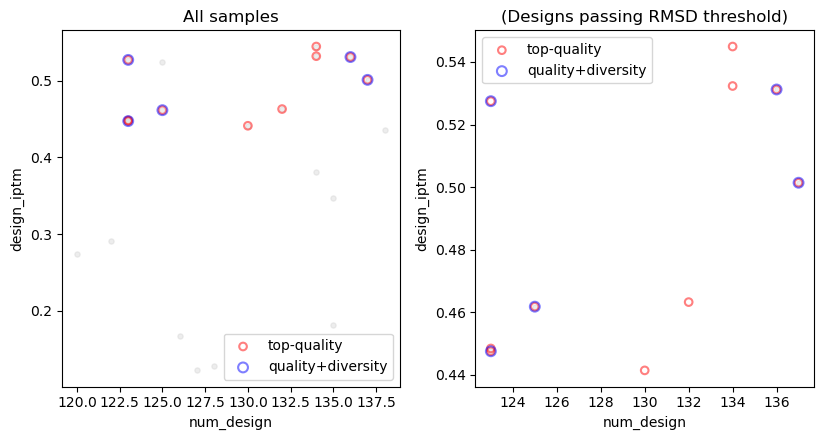

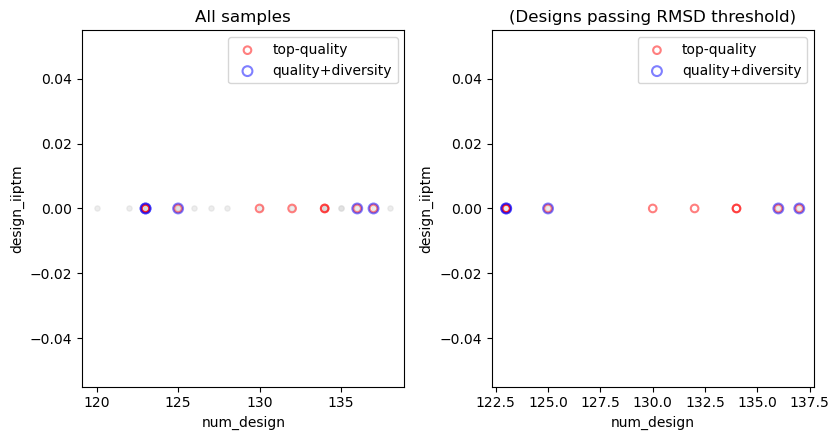

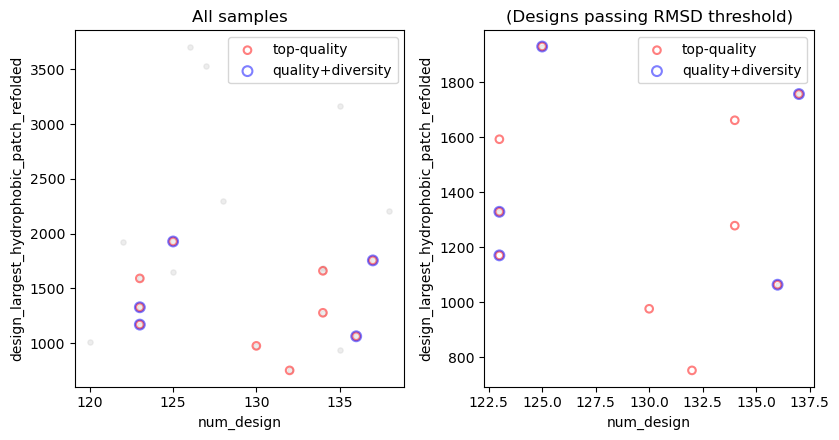

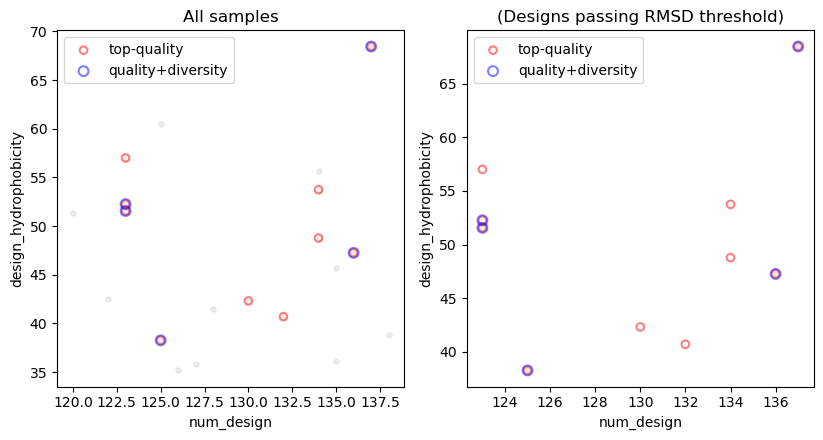

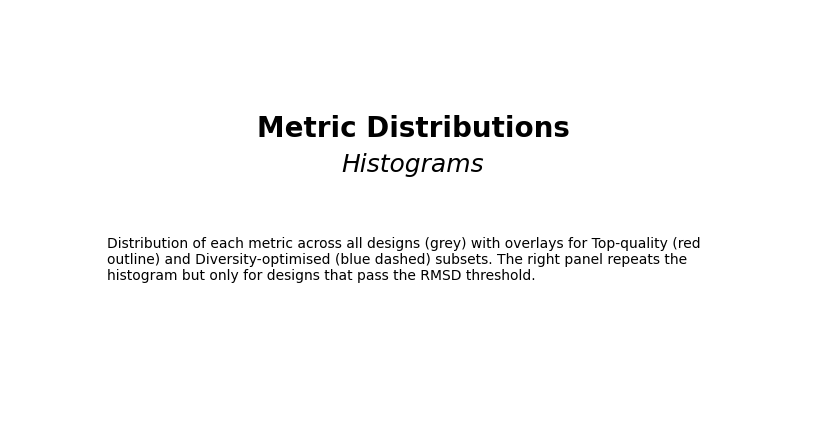

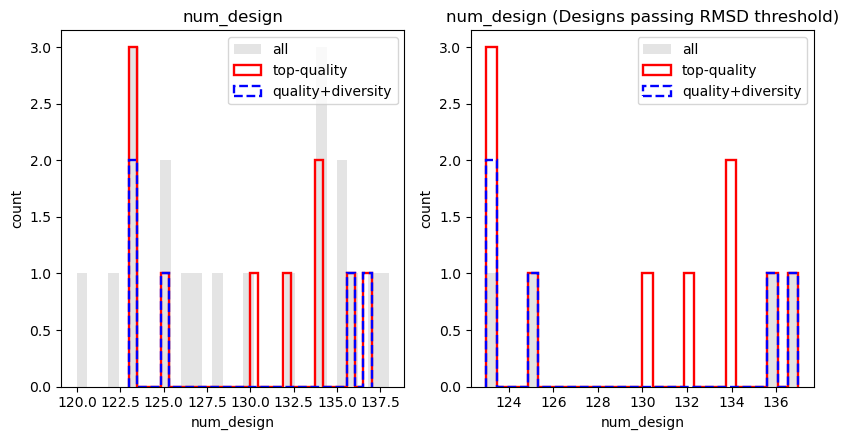

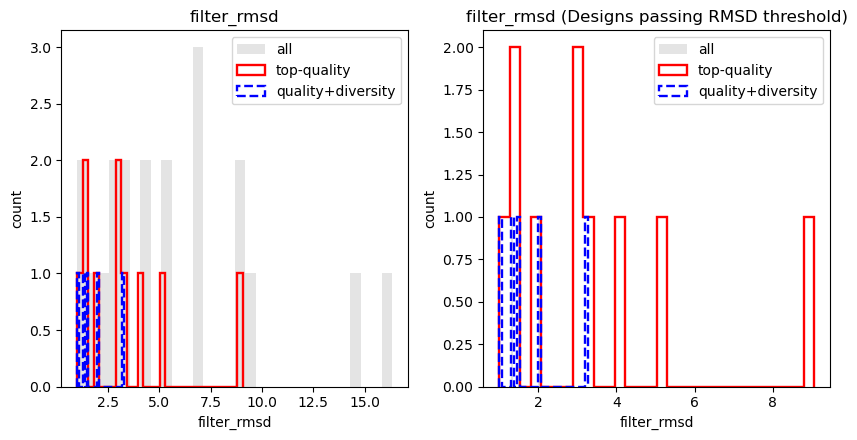

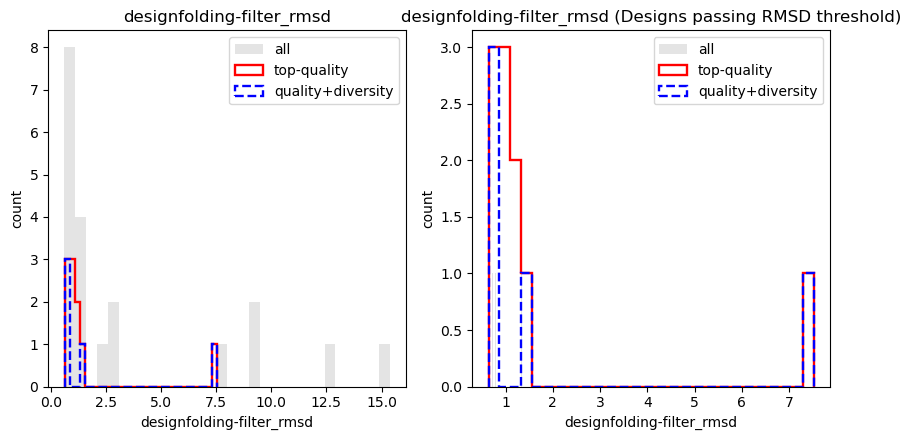

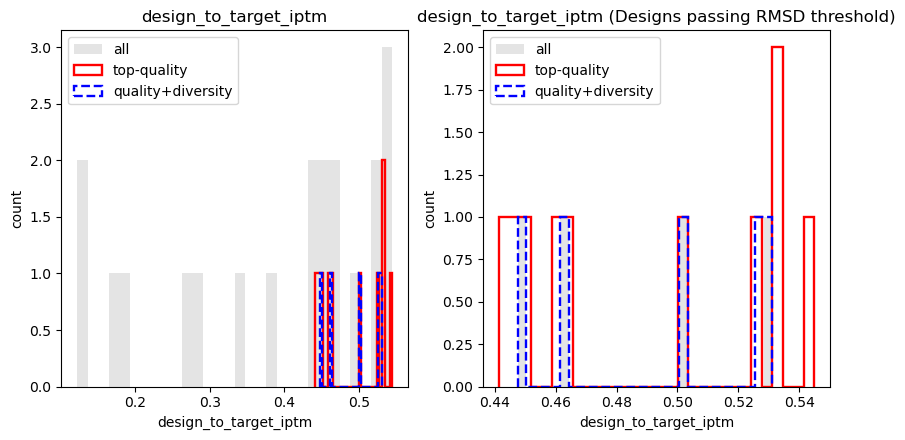

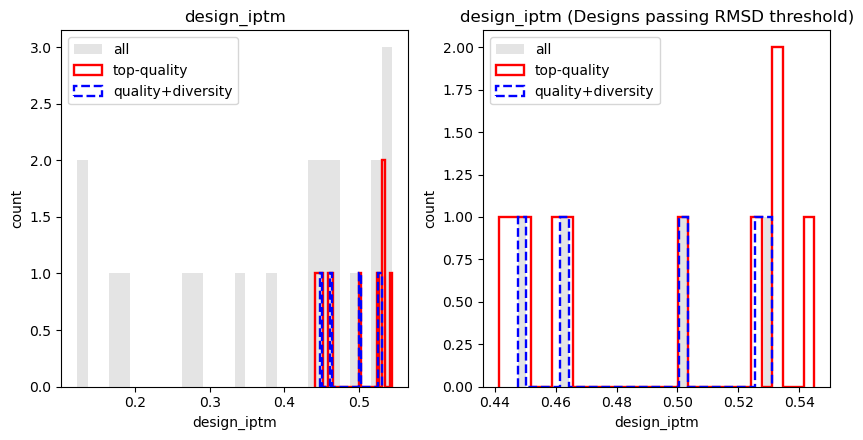

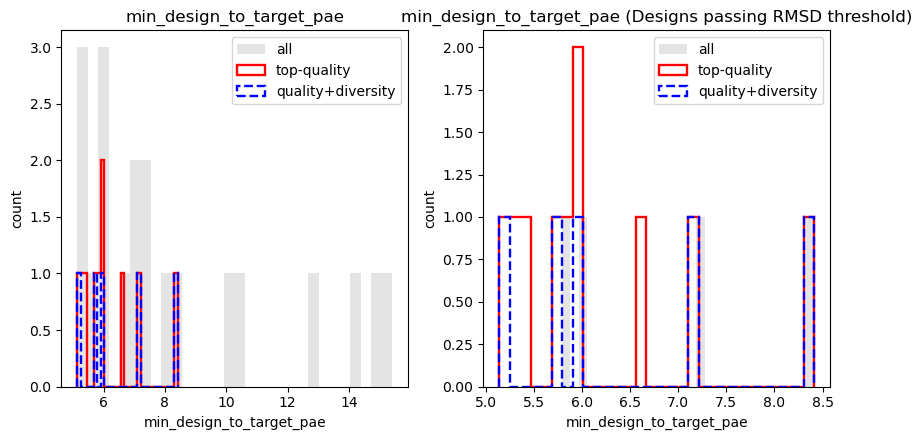

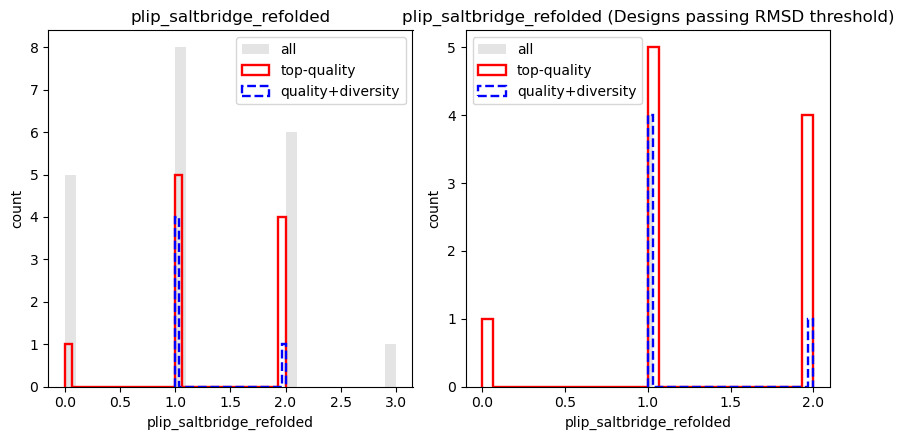

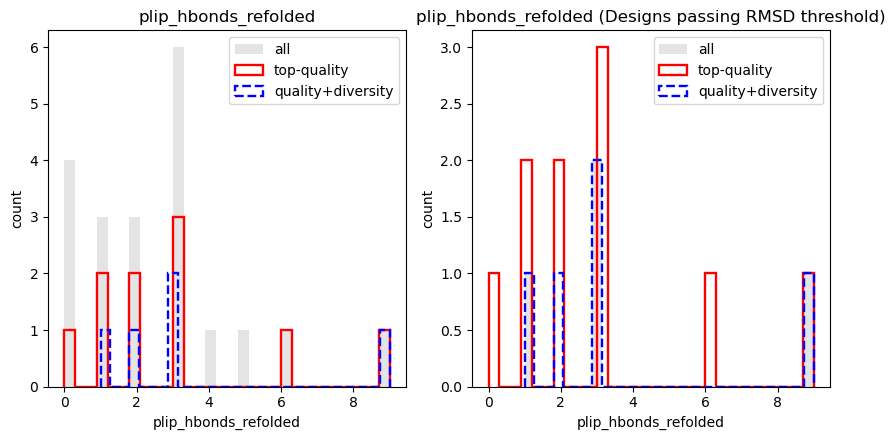

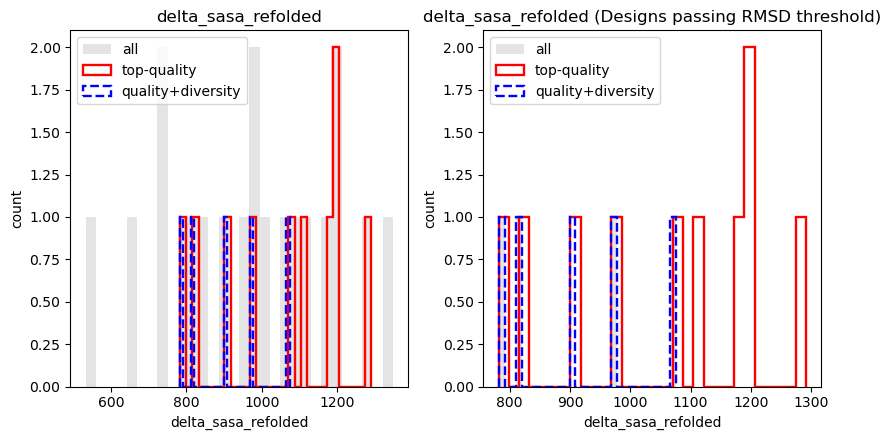

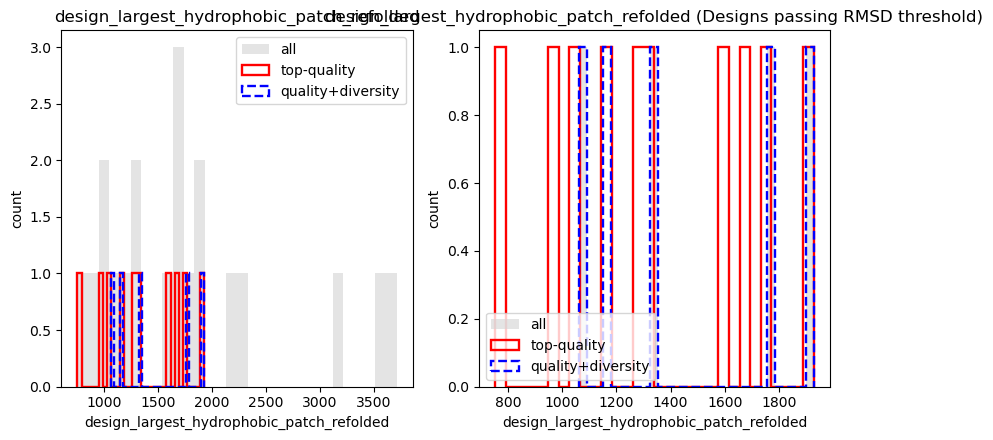

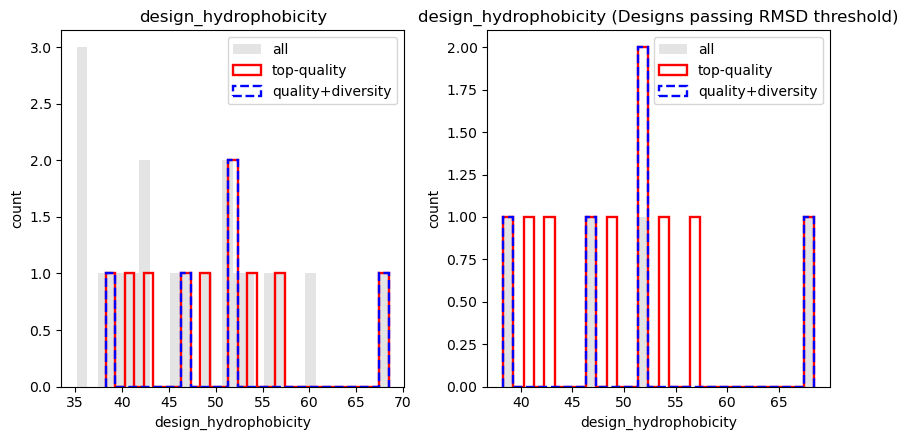

Making liability plots for top 0 sequences.: 0it [00:00, ?it/s]

A description of metrics and summarizing plots was written to: /tmp/workbench/tpp4/refiltered/final_ranked_designs/results_overview.pdf


In [14]:
from boltzgen.task.filter.filter import Filter
from pathlib import Path

workdir = Path("/tmp/workbench/tpp4")

filter_task = Filter(
    design_dir=workdir / "intermediate_designs_inverse_folded",
    outdir=workdir / "refiltered",
    budget=5, # How many designs to subselect from all designs
    use_affinity=False,  # When designing binders to small molecules this should be true
    filter_bindingsite=False,  # This filters out everything that does not have a residue within 4A of a binding site residue
    filter_designfolding=False, # Filter by the RMSD when refolding only the designed part (usually true for proteins and false for nanobodies or peptides)
    refolding_rmsd_threshold=2.5,
    alpha=0.3,  # for diversity quality optimization: 0 = quality-only, 1 = diversity-only
    metrics_override={
        "design_ptm": 2,
        "neg_min_design_to_target_pae": 1,
        "design_iiptm": 1,
        "plip_hbonds_refolded": 4,
        "plip_saltbridge_refolded": None,
        "delta_sasa_refolded": 4,
        "neg_design_hydrophobicity": 7,
        "neg_design_largest_hydrophobic_patch_refolded": 9,
    },
    size_buckets=[
        {"num_designs": 10, "min": 50, "max": 100}, # maximum number of designs that are allowed in the final selected diverse set
        {"num_designs": 10, "min": 100, "max": 150},
        {"num_designs": 10, "min": 150, "max": 200},
    ],
    additional_filters=[
        {"feature": "design_ptm", "lower_is_better": False, "threshold": 0.7},
        {"feature": "sheet", "lower_is_better": True, "threshold": 0.8},
    ],
)
filter_task.run(jupyter_nb=True)

In [15]:
# All designs
import pandas as pd
df = pd.read_csv(filter_task.outdir / "all_designs_metrics.csv")
df

,id,final_rank,designed_sequence,designed_chain_sequence,num_design,design_to_target_iptm,min_design_to_target_pae,design_ptm,filter_rmsd,designfolding-filter_rmsd,...,rank_design_iiptm,rank_design_ptm,rank_neg_min_design_to_target_pae,rank_plip_hbonds_refolded,rank_delta_sasa_refolded,rank_neg_design_hydrophobicity,rank_neg_design_largest_hydrophobic_patch_refolded,max_rank,secondary_rank,quality_score
0,tpp4_17,1,GPLVAEGTATKATLDGNTLTIEFEATVTLGDDTATVRGTVTITVDG...,GPLVAEGTATKATLDGNTLTIEFEATVTLGDDTATVRGTVTITVDG...,136,0.53120,5.78759,0.79321,2.04296,1.34117,...,1.0,0.5,1.0,0.25,0.25,0.142857,0.111111,1.0,1,1.000000
1,tpp4_12,2,MDAVEGVAAGVAKYAGEEVGAAAREAVERGRAAGDPETGLAGAVVG...,MDAVEGVAAGVAKYAGEEVGAAAREAVERGRAAGDPETGLAGAVVG...,125,0.46178,5.96758,0.79756,1.00589,0.72989,...,2.0,1.0,2.0,0.50,0.50,0.285714,0.222222,2.0,2,0.947368
2,tpp4_09,3,GLAATLARLGAICAELHRVLQTGDLEEIREAVRRALYEITQLIEQH...,GLAATLARLGAICAELHRVLQTGDLEEIREAVRRALYEITQLIEQH...,137,0.50139,7.20269,0.82327,1.51766,0.78923,...,3.0,1.5,3.0,0.75,0.75,0.571429,0.444444,3.0,3,0.894737
3,tpp4_16,4,GSLTTEELLELVAQAALEGLKEAGGDPRRAAAVGAKIVCAKLAELG...,GSLTTEELLELVAQAALEGLKEAGGDPRRAAAVGAKIVCAKLAELG...,123,0.44752,8.41344,0.75891,1.32633,0.63900,...,3.0,2.0,4.0,1.00,1.00,0.428571,0.333333,4.0,4,0.842105
4,tpp4_02,5,GAIEEEKRLSNDPSLLATAAQITAEIRERLGDDYVPVLVVFDKETA...,GAIEEEKRLSNDPSLLATAAQITAEIRERLGDDYVPVLVVFDKETA...,123,0.52746,5.13670,0.81640,3.28244,7.52009,...,5.0,3.0,5.0,3.00,3.75,2.285714,1.000000,5.0,5,0.789474
5,tpp4_06,6,GSALSGTYKLVSSDGVRAAAEALGLDPEKLLADFKLTITVSPDGKT...,GSALSGTYKLVSSDGVRAAAEALGLDPEKLLADFKLTITVSPDGKT...,134,0.53231,5.31773,0.75110,4.11984,1.11919,...,5.0,6.0,6.0,3.75,1.75,2.428571,1.444444,6.0,6,0.736842
6,tpp4_04,7,ASGTYEVTDVLVSEEATEEQKARAERLLRERAEAKITVGEDTVTVE...,ASGTYEVTDVLVSEEATEEQKARAERLLRERAEAKITVGEDTVTVE...,134,0.54493,5.41626,0.82307,9.05834,0.89877,...,5.0,2.5,7.0,3.00,2.25,2.000000,1.111111,7.0,7,0.684211
7,tpp4_13,8,GYTVTSVTLKALNPRTGEGTDPVTGAGAADGSASAELEAEDGSIVI...,GYTVTSVTLKALNPRTGEGTDPVTGAGAADGSASAELEAEDGSIVI...,132,0.46324,5.82889,0.75838,3.00638,1.19498,...,5.0,5.0,8.0,4.25,2.50,1.285714,0.555556,8.0,8,0.631579
8,tpp4_05,9,MTVESPETPELTPEEVRAEVERALPVVLRALREHPNTLVLFAVNGE...,MTVESPETPELTPEEVRAEVERALPVVLRALREHPNTLVLFAVNGE...,123,0.44842,5.95820,0.80805,3.11270,0.88682,...,5.0,4.0,9.0,1.25,2.00,2.714286,1.222222,9.0,9,0.578947
9,tpp4_07,10,MAVVTGSGRTEPASVTVGDTEPLNYYAEADAATQQVSVYVEGPGFN...,MAVVTGSGRTEPASVTVGDTEPLNYYAEADAATQQVSVYVEGPGFN...,130,0.44141,6.61996,0.76551,5.12478,1.05829,...,5.0,4.5,10.0,2.00,1.50,1.571429,0.777778,10.0,10,0.526316


In [21]:
# Final designs
df = pd.read_csv(filter_task.outdir / f"final_designs_metrics_{filter_task.budget}.csv")
df

,id,final_rank,designed_sequence,designed_chain_sequence,num_design,design_to_target_iptm,min_design_to_target_pae,design_ptm,filter_rmsd,designfolding-filter_rmsd,...,rank_design_ptm,rank_neg_min_design_to_target_pae,rank_plip_hbonds_refolded,rank_delta_sasa_refolded,rank_neg_design_hydrophobicity,rank_neg_design_largest_hydrophobic_patch_refolded,max_rank,secondary_rank,quality_score,sequence
0,tpp4_17,1,GPLVAEGTATKATLDGNTLTIEFEATVTLGDDTATVRGTVTITVDG...,GPLVAEGTATKATLDGNTLTIEFEATVTLGDDTATVRGTVTITVDG...,136,0.53120,5.78759,0.79321,2.04296,1.34117,...,0.5,1.0,0.25,0.25,0.142857,0.111111,1.0,1,1.000000,GPLVAEGTATKATLDGNTLTIEFEATVTLGDDTATVRGTVTITVDG...
1,tpp4_12,2,MDAVEGVAAGVAKYAGEEVGAAAREAVERGRAAGDPETGLAGAVVG...,MDAVEGVAAGVAKYAGEEVGAAAREAVERGRAAGDPETGLAGAVVG...,125,0.46178,5.96758,0.79756,1.00589,0.72989,...,1.0,2.0,0.50,0.50,0.285714,0.222222,2.0,2,0.947368,MDAVEGVAAGVAKYAGEEVGAAAREAVERGRAAGDPETGLAGAVVG...
2,tpp4_09,3,GLAATLARLGAICAELHRVLQTGDLEEIREAVRRALYEITQLIEQH...,GLAATLARLGAICAELHRVLQTGDLEEIREAVRRALYEITQLIEQH...,137,0.50139,7.20269,0.82327,1.51766,0.78923,...,1.5,3.0,0.75,0.75,0.571429,0.444444,3.0,3,0.894737,GLAATLARLGAICAELHRVLQTGDLEEIREAVRRALYEITQLIEQH...
3,tpp4_16,4,GSLTTEELLELVAQAALEGLKEAGGDPRRAAAVGAKIVCAKLAELG...,GSLTTEELLELVAQAALEGLKEAGGDPRRAAAVGAKIVCAKLAELG...,123,0.44752,8.41344,0.75891,1.32633,0.63900,...,2.0,4.0,1.00,1.00,0.428571,0.333333,4.0,4,0.842105,GSLTTEELLELVAQAALEGLKEAGGDPRRAAAVGAKIVCAKLAELG...
4,tpp4_02,5,GAIEEEKRLSNDPSLLATAAQITAEIRERLGDDYVPVLVVFDKETA...,GAIEEEKRLSNDPSLLATAAQITAEIRERLGDDYVPVLVVFDKETA...,123,0.52746,5.13670,0.81640,3.28244,7.52009,...,3.0,5.0,3.00,3.75,2.285714,1.000000,5.0,5,0.789474,GAIEEEKRLSNDPSLLATAAQITAEIRERLGDDYVPVLVVFDKETA...
